In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
from prediction.functions import new_r2

In [2]:
PREDICTION_MODEL = ['lasso', 'ridge', 'enet', 'random_forest', 'lgb', 'nn3']
FS_METHODS = ['all', 'granger', 'huang', 'IAMB', 'mda', 'mdi', 'MMMB', 'sfi']
EVALUATION_START = '2012-07-03'

## Selected Features

In [3]:
# features = []

# for fs in FS_METHODS:
#     assets = glob('results/feature_selection/' + fs + '/indices/*.csv')
#     for asset_path in assets:
#         df = pd.read_csv(asset_path)

#         r2_eval_df = df.copy()
#         r2_eval_df.set_index('date', inplace=True)
#         r2_eval_df = r2_eval_df.loc[EVALUATION_START:]
#         r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
#         r2_df = pd.DataFrame([{'model': model,
#                             'fs': fs,
#                             'r2': r2}])
#         r2s.append(r2_df)

#         melt_df = df.melt('date')
#         melt_df['model'] = model
#         melt_df['fs'] = fs
#         predictions.append(melt_df)

# features_df = pd.concat(features, axis=0)

## Aggregate prediction results

In [4]:
predictions = []
r2s = []

for model in PREDICTION_MODEL:
    for fs in FS_METHODS:
        assets = glob('results/forecast/' + fs + '/indices/' + model + '/*.csv')
        for asset_path in assets:
            df = pd.read_csv(asset_path)
            df.set_index('date', inplace=True)
            df = df.loc[EVALUATION_START:]
            df = df.reset_index()

            r2_eval_df = df.copy()
            r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
            r2_df = pd.DataFrame([{'model': model,
                                'fs': fs,
                                'r2': r2}])
            r2s.append(r2_df)

            melt_df = df.melt('date')
            melt_df['model'] = model
            melt_df['fs'] = fs
            predictions.append(melt_df)

predictions_df = pd.concat(predictions, axis=0)
r2_df = pd.concat(r2s, axis=0)

## R2 -  Gu, Kelly, and Xiu (2020)

In [5]:
r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100

r2                                                        
model        enet     lasso       lgb       nn3 random_forest       ridge
fs                                                                       
IAMB    -0.125386  0.194931  0.091345 -9.683188     -2.015956   -3.200634
MMMB     0.145037  0.260719  0.249900 -0.253133     -2.054485   -2.445411
all      0.260719  0.260719 -0.021936 -0.320744      0.618477 -610.099022
granger  0.260719  0.260719  0.226518  0.051103      0.485445   -4.891654
huang    0.216428  0.160888  0.149066 -0.124528      0.239312    0.124308
mda      0.260719  0.260719  0.320499  0.309241     -0.003625  -65.984130
mdi      0.260719  0.260719  0.262052  0.299551     -0.102545 -110.691437
sfi      0.260719  0.260719  0.289977  0.090549     -0.039325 -406.262967

In [6]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)

fs
IAMB       -14.738888
MMMB        -4.097373
all       -609.301787
granger     -3.607149
huang        0.765474
mda        -64.836576
mdi       -109.710940
sfi       -405.400329
dtype: float64

In [7]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)/(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).std(axis=1)

fs
IAMB      -3.885968
MMMB      -3.319392
all       -2.445648
granger   -1.712448
huang      5.853113
mda       -2.398524
mdi       -2.423486
sfi       -2.443250
dtype: float64

## OOS portfolio returns

In [21]:
model = 'lgb'

benchmark_buynhold_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] == 'return')&(predictions_df['fs'] == 'all')]
benchmark_buynhold_df = benchmark_buynhold_df.pivot_table(index=['date'], columns=['variable'], values=['value'])

fs_model_pred_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] != 'return')]
fs_model_pred_df = fs_model_pred_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
names = fs_model_pred_df.columns.droplevel()
fs_model_ret_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1) * benchmark_buynhold_df.values)
fs_model_ret_df.columns = names
fs_model_ret_df.index = benchmark_buynhold_df.index

all_ret = pd.concat([fs_model_ret_df, benchmark_buynhold_df], axis=1)

<AxesSubplot:xlabel='date'>

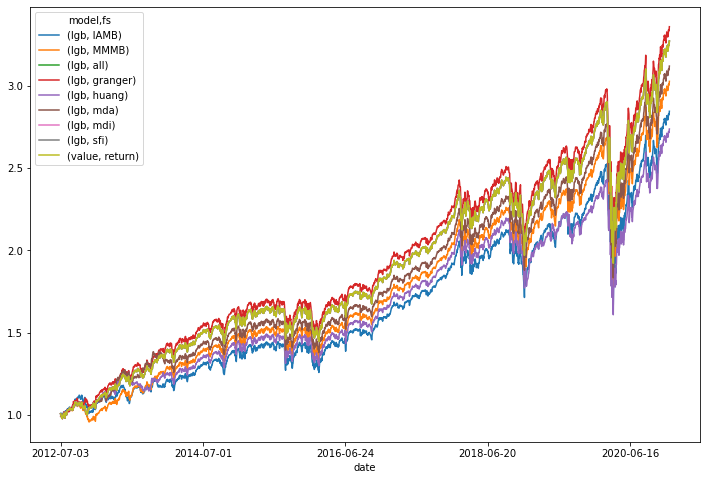

In [22]:
(1 + all_ret).cumprod().plot(figsize=(12, 8))

In [23]:

all_ret = pd.concat([fs_model_ret_df, benchmark_buynhold_df], axis=1)
benchmark_buynhold_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] == 'return')&(predictions_df['fs'] == 'all')]
benchmark_buynhold_df = benchmark_buynhold_df.pivot_table(index=['date'], columns=['variable'], values=['value'])
melt_benchmark_buynhold_df = benchmark_buynhold_df.reset_index().melt('date')
melt_benchmark_buynhold_df.rename(columns={melt_benchmark_buynhold_df.columns[1]: 'model',
                                           melt_benchmark_buynhold_df.columns[2]: 'fs'}, inplace=True)

metrics_df = []
positions_df = []
for model in PREDICTION_MODEL:
    fs_model_pred_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] != 'return')]
    fs_model_pred_df = fs_model_pred_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
    names = fs_model_pred_df.columns.droplevel()
    fs_model_ret_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1) * benchmark_buynhold_df.values)
    fs_model_ret_df.columns = names
    fs_model_ret_df.index = benchmark_buynhold_df.index
    metrics_df.append(fs_model_ret_df.reset_index().melt('date'))

    positons_fs_model_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1))
    positons_fs_model_df.columns = names
    positons_fs_model_df.index = benchmark_buynhold_df.index
    positions_df.append(positons_fs_model_df.reset_index().melt('date'))

positions_df = pd.concat(positions_df, axis=0)
pivot_positions_df = positions_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
metrics_ex_ret_df = pd.concat(metrics_df, axis=0)
metrics_df = pd.concat([metrics_ex_ret_df, melt_benchmark_buynhold_df], axis=0)
pivot_metrics_df = metrics_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])

<ipython-input-23-386e13108ffb>:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melt_benchmark_buynhold_df = benchmark_buynhold_df.reset_index().melt('date')


## Sharpe ratio

### Ranking

In [26]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).sort_values(ascending=False)

       model          fs     
value  random_forest  all        1.023986
                      mdi        1.018073
       lgb            granger    0.932157
       random_forest  IAMB       0.925699
       value          return     0.913600
       lasso          granger    0.913600
       lgb            sfi        0.913600
                      mdi        0.913600
                      all        0.913600
       lasso          sfi        0.913600
                      mda        0.913600
                      mdi        0.913600
                      all        0.913600
       enet           sfi        0.913600
                      mdi        0.913600
       lasso          MMMB       0.913600
       enet           mda        0.913600
                      all        0.913600
                      granger    0.913600
       random_forest  MMMB       0.886952
       lgb            mda        0.880327
                      MMMB       0.859163
       nn3            mda        0.834678
    

### Ranking by FS vs ML

In [27]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB     0.762091  0.794736  0.815709  0.459428      0.925699 -0.197376   
MMMB     0.764929  0.913600  0.859163  0.491413      0.886952 -0.064499   
all      0.913600  0.913600  0.913600  0.317609      1.023986  0.227048   
granger  0.913600  0.913600  0.932157  0.476327      0.638345  0.252197   
huang    0.792818  0.535066  0.788681 -0.132437      0.746478  0.381632   
mda      0.913600  0.913600  0.880327  0.834678      0.692309 -0.854822   
mdi      0.913600  0.913600  0.913600  0.778677      1.018073  0.738536   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi      0.913600  0.913600  0.913600  0.724314      0.695513 -0.375178   

                 
model     value  
fs               
IAMB        NaN  
MMMB        NaN  
all         NaN  
granger     NaN  
huang       NaN  
mda         NaN  
mdi         NaN  
return   0.9136  
sfi         NaN

### Mean SR per FS method

In [32]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
return     0.913600
mdi        0.879348
all        0.718241
granger    0.687704
MMMB       0.641926
sfi        0.630908
IAMB       0.593381
mda        0.563282
huang      0.518706
dtype: float64

### Mean SR controlling by the std per FS method

In [41]:
(((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / ((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
mdi        8.563082
granger    2.435673
all        2.056736
MMMB       1.694148
huang      1.446502
IAMB       1.420800
sfi        1.254386
mda        0.805135
return          NaN
dtype: float64

## Hit rate

### Ranking

In [33]:
discrete_returns = np.where(benchmark_buynhold_df > 0, 1, 0)
discrete_positions = np.where(pivot_positions_df > 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
buys_hit_rate_per_asset = mult.sum(axis=0)

discrete_returns = np.where(benchmark_buynhold_df <= 0, 1, 0)
discrete_positions = np.where(pivot_positions_df <= 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
sells_hit_rate_per_asset = mult.sum(axis=0)

hit_rate_per_asset = (buys_hit_rate_per_asset + sells_hit_rate_per_asset) / pivot_positions_df.notnull().count(axis=0)
hit_rate_per_asset.sort_values(ascending=False)

       model          fs     
value  random_forest  mdi        0.557737
       lgb            all        0.556802
       lasso          MMMB       0.556802
                      sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
       lgb            sfi        0.556802
       lasso          all        0.556802
                      granger    0.556802
       enet           sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
                      granger    0.556802
                      all        0.556802
       lgb            mdi        0.556802
       random_forest  huang      0.556335
       nn3            mda        0.555400
       lgb            granger    0.555400
                      MMMB       0.554932
       lasso          IAMB       0.553997
       nn3            mdi        0.553997
       enet           MMMB       0.553530
       lgb            huang      0.551660
    

### Ranking by FS vs ML

In [34]:
hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                      
model        enet     lasso       lgb       nn3 random_forest     ridge
fs                                                                     
IAMB     0.550725  0.553997  0.550725  0.534829      0.545115  0.502571
MMMB     0.553530  0.556802  0.554932  0.534829      0.546050  0.501169
all      0.556802  0.556802  0.556802  0.524544      0.548387  0.513324
granger  0.556802  0.556802  0.555400  0.540907      0.540907  0.504441
huang    0.549790  0.541842  0.551660  0.499766      0.556335  0.531089
mda      0.556802  0.556802  0.550725  0.555400      0.550257  0.475923
mdi      0.556802  0.556802  0.556802  0.553997      0.557737  0.511454
sfi      0.556802  0.556802  0.556802  0.547452      0.547920  0.499766

### Mean Hit rate per FS method

In [36]:
hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
mdi        0.548933
sfi        0.544257
all        0.542777
granger    0.542543
MMMB       0.541219
mda        0.540985
IAMB       0.539660
huang      0.538414
dtype: float64

 ### Mean Hit rate controlling by the std per FS method

In [43]:
(hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
mdi        29.826108
all        28.437438
IAMB       27.837764
granger    26.932352
huang      25.755484
MMMB       25.509747
sfi        24.461566
mda        16.902463
dtype: float64

## Maximum drawdown

### Rank

In [37]:
cum_prod_df = (1 + pivot_metrics_df).cumprod()
previous_peaks_df =  cum_prod_df.cummax()
drawdown_df = (cum_prod_df - previous_peaks_df)/previous_peaks_df
drawdown_df.min().sort_values(ascending=False)

       model          fs     
value  random_forest  all       -0.214737
       nn3            sfi       -0.219324
       random_forest  IAMB      -0.253855
                      granger   -0.260240
                      MMMB      -0.271659
       nn3            mdi       -0.278116
       random_forest  sfi       -0.294094
                      mdi       -0.321627
       ridge          mdi       -0.324908
       random_forest  huang     -0.337904
       enet           mda       -0.337904
       lgb            sfi       -0.337904
                      mdi       -0.337904
       enet           all       -0.337904
                      granger   -0.337904
       lgb            all       -0.337904
       enet           sfi       -0.337904
       lasso          MMMB      -0.337904
                      sfi       -0.337904
                      mdi       -0.337904
                      mda       -0.337904
       enet           mdi       -0.337904
       lasso          granger   -0.337904
    

### Rank by FS vs ML

In [38]:
drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB    -0.337904 -0.337904 -0.337904 -0.443924     -0.253855 -0.467250   
MMMB    -0.337904 -0.337904 -0.337904 -0.337904     -0.271659 -0.400009   
all     -0.337904 -0.337904 -0.337904 -0.388233     -0.214737 -0.391322   
granger -0.337904 -0.337904 -0.337904 -0.337904     -0.260240 -0.435665   
huang   -0.337904 -0.337904 -0.337904 -0.443924     -0.337904 -0.428313   
mda     -0.337904 -0.337904 -0.337904 -0.337904     -0.350534 -0.755698   
mdi     -0.337904 -0.337904 -0.337904 -0.278116     -0.321627 -0.324908   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi     -0.337904 -0.337904 -0.337904 -0.219324     -0.294094 -0.690154   

                   
model       value  
fs                 
IAMB          NaN  
MMMB          NaN  
all           NaN  
granger       NaN  
huang         NaN  
mda           NaN  
mdi           NaN  
return  -0.337904  
sfi           NaN

### Mean Max drawdown per FS method

In [44]:
drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1).sort_values(ascending=False)

fs
mdi       -0.323060
all       -0.334667
MMMB      -0.337214
return    -0.337904
granger   -0.341253
IAMB      -0.363123
sfi       -0.369547
huang     -0.370642
mda       -0.409641
dtype: float64

### Mean Max drawdown controlling by the std per FS method

In [45]:
(drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).mean(axis=1) / drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0]).std(axis=1)).sort_values(ascending=False)

fs
sfi        -2.256926
mda        -2.415228
IAMB       -4.595480
all        -5.227423
granger    -6.124805
huang      -7.273538
MMMB       -8.305316
mdi       -13.937210
return           NaN
dtype: float64

## Probability of Backtest Overfitting (PBO) Bailey et al. (2013)